In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import pandas as pd
import seaborn as sns
import re

In [20]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

def count_images(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))])

def augment_images(src_folder, dst_folder, nb_to_generate, prefix='aug_'):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.9, 1.1]
    )
    files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))]
    for i in range(nb_to_generate):
        f = random.choice(files)
        img_path = os.path.join(src_folder, f)
        img = load_img(img_path, target_size=(224,224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        it = datagen.flow(x, batch_size=1)
        batch = next(it)
        save_img(os.path.join(dst_folder, f"{prefix}{i:05d}_{f}"), batch[0])

def balance_split(base_dir, split, normal_count, pneumonia_count):
    normal_dir = os.path.join(base_dir, split, 'NORMAL')
    pneumonia_dir = os.path.join(base_dir, split, 'PNEUMONIA')
    n_normal = count_images(normal_dir)
    n_pneumonia = count_images(pneumonia_dir)
    if n_normal < n_pneumonia:
        augment_images(normal_dir, normal_dir, n_pneumonia - n_normal)
    elif n_normal > n_pneumonia:
        files = [f for f in os.listdir(normal_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))]
        random.shuffle(files)
        for f in files[n_pneumonia:]:
            os.remove(os.path.join(normal_dir, f))

def main():
    base_dir = '../../T_DEV_810/chest_xray'
    for split in ['train', 'val', 'test']:
        normal_dir = os.path.join(base_dir, split, 'NORMAL')
        pneumonia_dir = os.path.join(base_dir, split, 'PNEUMONIA')
        n_normal = count_images(normal_dir)
        n_pneumonia = count_images(pneumonia_dir)
        balance_split(base_dir, split, n_normal, n_pneumonia)

main()


In [21]:
import os
import shutil
import numpy as np

def move_files(files, src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for f in files:
        shutil.move(os.path.join(src_dir, f), os.path.join(dst_dir, f))

def repartition(base_dir, classes, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    splits = ['train', 'val', 'test']
    temp_dir = os.path.join(base_dir, 'temp_repartition')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    for cls in classes:
        cls_temp_dir = os.path.join(temp_dir, cls)
        if not os.path.exists(cls_temp_dir):
            os.makedirs(cls_temp_dir)
        for split in splits:
            src_folder = os.path.join(base_dir, split, cls)
            if os.path.exists(src_folder):
                files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))]
                for f in files:
                    shutil.move(os.path.join(src_folder, f), os.path.join(cls_temp_dir, f))
    for cls in classes:
        cls_temp_dir = os.path.join(temp_dir, cls)
        files = [f for f in os.listdir(cls_temp_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))]
        np.random.seed(42)
        np.random.shuffle(files)
        n = len(files)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]
        move_files(train_files, cls_temp_dir, os.path.join(base_dir, 'train', cls))
        move_files(val_files, cls_temp_dir, os.path.join(base_dir, 'val', cls))
        move_files(test_files, cls_temp_dir, os.path.join(base_dir, 'test', cls))
    for cls in classes:
        cls_temp_dir = os.path.join(temp_dir, cls)
        if os.path.exists(cls_temp_dir):
            os.rmdir(cls_temp_dir)
    if os.path.exists(temp_dir):
        os.rmdir(temp_dir)

base_dir = '../../T_DEV_810/chest_xray'
classes = ['NORMAL', 'PNEUMONIA']

repartition(base_dir, classes)

Structure du dossier et nombre d'images par split et classe :

TRAIN:
  NORMAL: 6652 images
  PNEUMONIA: 5982 images

VAL:
  NORMAL: 1425 images
  PNEUMONIA: 1281 images

TEST:
  NORMAL: 1426 images
  PNEUMONIA: 1283 images


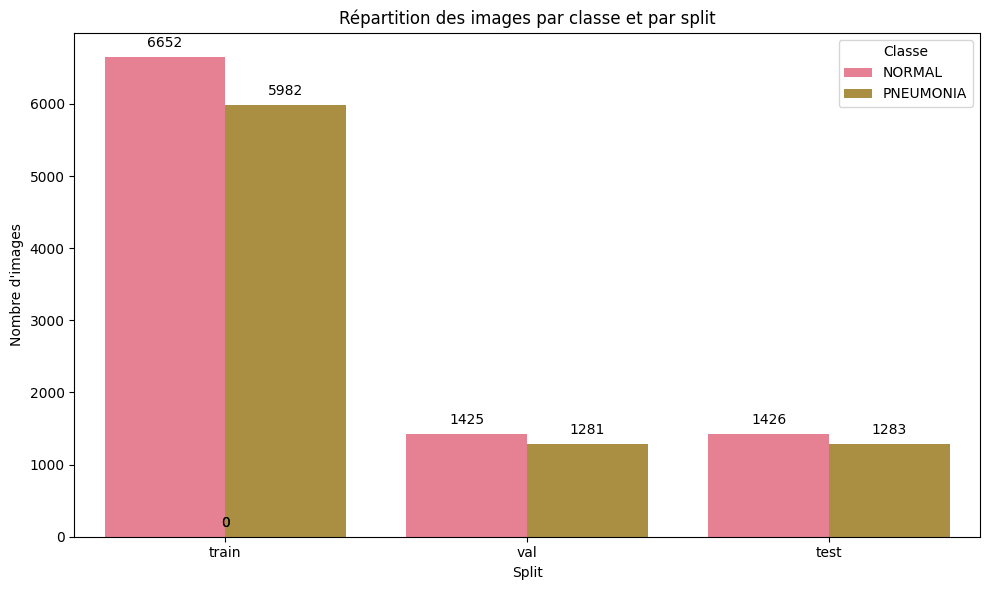

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_dir = '../../T_DEV_810/chest_xray'
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

data = []
for split in splits:
    for cls in classes:
        folder = os.path.join(base_dir, split, cls)
        n_images = len([f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff'))])
        data.append({'Split': split, 'Class': cls, 'Count': n_images})

df = pd.DataFrame(data)

print("Structure du dossier et nombre d'images par split et classe :")
for split in splits:
    print(f"\n{split.upper()}:")
    for cls in classes:
        count = df[(df['Split'] == split) & (df['Class'] == cls)]['Count'].values[0]
        print(f"  {cls}: {count} images")

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df, x='Split', y='Count', hue='Class')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10,
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Répartition des images par classe et par split')
plt.ylabel('Nombre d\'images')
plt.xlabel('Split')
plt.legend(title='Classe')
plt.tight_layout()
plt.show()


# Data Balancing and Augmentation: 70/15/15 Split with Class Equilibrium

## Problématique

Le dataset initial présente deux défis majeurs :
- Répartition inadéquate entre les sets train/val/test
- Déséquilibre entre les classes NORMAL et PNEUMONIA

## Solution : Redistribution et augmentation des données

## Points importants

### 🔄 **Processus de redistribution**
1. **Collecte** : Rassemble tous les fichiers des répertoires train/val/test originaux 
2. **Mélange** : Randomise l'ordre pour éviter les biais
3. **Split** : Divise selon le ratio 70/15/15
4. **Équilibrage** : Augmente la classe minoritaire pour atteindre un ratio 50/50
5. **Copie** : Place les fichiers dans les nouveaux répertoires

### 🔧 **Stratégie d'augmentation**
- Rotation (±20°)
- Translation horizontale/verticale (±10%)
- Zoom (±10%) 
- Variation de luminosité (±10%)
- Retournement horizontal
- Génération jusqu'à équilibre des classes

### ✅ **Avantages de cette approche**
- Équilibre parfait entre les classes
- Meilleure généralisation du modèle
- Réduction du biais de classe
- Seed fixe pour reproductibilité

> 💡 **Note** : Cette approche combine une distribution optimale des données (70/15/15) avec un équilibrage des classes, offrant une base solide pour l'entraînement du modèle.